# Exploratory Analysis of NEH Grant Data: 1960s

***

* **Author:** [Lucy Havens](https://lucyhavens.com)
* **Due Date:** September 16, 2023
* **Data source:** [Data.gov](https://catalog.data.gov/organization/neh-gov)
* **Aim:** Convey something of note about humanities or NEH grantmaking, demonstrating technical savvy, communication skills, and humanities literacy

***

**Contents**

[I.](#i) Data Loading

[II.](#ii) Quantities

[III.](#iii) Text Analysis

***

Import programming libraries:

In [1]:
# For custom functions:
import utils

# For XML data:
import xml.etree.ElementTree as ET

# For text data:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# For tabular data
import pandas as pd

# For creating directories
from pathlib import Path

# For visualizing data
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /Users/lucy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="i"></a>
## I. Data Loading

Import the XML data files of NEH grants from the 1960s through the 2020s:

In [2]:
datadir = "neh-data/"

In [3]:
y = 1960
filepath = datadir+"NEH_Grants{year}s/NEH_Grants{year}s.xml".format(year=y)


In [4]:
tree = ET.parse(filepath)
root = tree.getroot()

Extract the text for the following data fields:
* Project title (`<ProjectTitle>...</ProjectTitle>`)
* Year project awarded grant (`<YearAwarded>...</YearAwarded>`)
* Project description (`<ProjectDesc>...</ProjectDesc>`)
* Organization type (`<OrganizationType>...</OrganizationType>`)
* Primary discipline (`<PrimaryDiscipline>...</PrimaryDiscipline>`)

In [5]:
titles = utils.getTextBeneathTag(root, "ProjectTitle")
print("Total titles:", len(titles))
print("Sample titles:", list(set(titles))[0:3])

Total titles: 1010
Sample titles: ['The Papers of George Washington', 'Program to improve instruction dealing with the American Negro', 'American Studies Bibliographical Project']


In [6]:
years = utils.getTextBeneathTag(root, "YearAwarded")
# Represent years as numbers, rather than strings
grant_years = [int(grant_year) for grant_year in years]
print("Total years:", len(grant_years))
print("Range of years:", min(grant_years), "to", max(grant_years))

Total years: 1010
Range of years: 1966 to 1969


In [7]:
descriptions = utils.getTextBeneathTag(root, "ProjectDesc")
print("Total descriptions:", len(descriptions))
print("Sample description:", list(set(descriptions))[0])

Total descriptions: 1010
Sample description: Study of reform activities of the Consumers' Leagues, comparing European leagues with those in U.S. 


In [8]:
organizations = utils.getTextBeneathTag(root, "OrganizationType")
print("Total organizations:", len(organizations))
print("Unique organizations:", len(set(organizations)))
print("Sample organizations:", list(set(organizations))[0:3])

Total organizations: 1010
Unique organizations: 26
Sample organizations: ['Library', 'Professional Association', 'Philanthropic Foundation']


In [9]:
disciplines = utils.getTextBeneathTag(root, "PrimaryDiscipline")
print("Total primary disciplines:", len(disciplines))
print("Unique primary disciplines:", len(set(disciplines)))
print("Sample primary disciplines:", list(set(disciplines))[0:3])

Total primary disciplines: 1010
Unique primary disciplines: 57
Sample primary disciplines: ['Italian Literature', 'Archaeology', 'Classical Languages']


Ensure no data was missed:

In [10]:
assert len(titles) == len(descriptions), "There should be the same number of retrieved titles and descriptions."
assert len(titles) == len(organizations), "There should be the same number of retrieved titles and organizations."
assert len(disciplines) == len(organizations), "There should be the same number of retrieved disciplines and organizations."

<a id="ii"></a>
## II. Quantities

Create a table (specifically a *DataFrame*, a type of data structure in [pandas](pandas.pydata.org)) with the year, title, organization, and discipline data:

In [11]:
df = pd.DataFrame({"YearAwarded":grant_years, "ProjectTitle":titles, 
                   "OrganizationType":organizations, "PrimaryDiscipline":disciplines})
# Sort ascending by year, then title, then organization type, then discipline
df = df.sort_values(by=["YearAwarded","ProjectTitle","OrganizationType","PrimaryDiscipline"])
# Ensure no data was missed
assert df.shape[0] == len(disciplines), "There should be the same number of DataFrame rows as retrieved list items"
# View the initial rows of the DataFrame
df.head()

,YearAwarded,ProjectTitle,OrganizationType,PrimaryDiscipline
431,1966,A Project for Creation of Source Materials in ...,Center For Advanced Study/Research Institute,U.S. History
585,1966,Conference to Analyze Present Situation of Lat...,Four-Year College,Classical Languages
873,1966,Ming Biographical History Project,Center For Advanced Study/Research Institute,East Asian History
47,1966,Summer institute in papyrology to be conducted...,Professional Association,Ancient Literature
414,1966,Support of Standard Editions of American Authors,Center For Advanced Study/Research Institute,"Literature, General"


Calculate the sum of grants awarded to each organization type and save the data:

In [12]:
df_orgs = pd.DataFrame(df.OrganizationType.value_counts()).reset_index()
df_orgs = df_orgs.rename(columns={"index":"OrganizationType", "OrganizationType":"Count"})
df_orgs.head()

,OrganizationType,Count
0,Four-Year College,361
1,University,298
2,Center For Advanced Study/Research Institute,98
3,Publishing,71
4,Unknown,66


In [13]:
# Make a folder (a.k.a. directory) to save the organization type counts data into
analysis_dir = "analysis-data/"
Path(analysis_dir).mkdir(parents=True, exist_ok=True)
df_orgs.to_csv(analysis_dir+"organizationtype-counts-{year}s.csv".format(year=y))

Calculate the sum of primary disciplines and save the data:

In [14]:
df_discs = pd.DataFrame(df.PrimaryDiscipline.value_counts()).reset_index()
df_discs = df_discs.rename(columns={"index":"PrimaryDiscipline", "PrimaryDiscipline":"Count"})
df_discs.head()

,PrimaryDiscipline,Count
0,"History, General",237
1,"Interdisciplinary Studies, General",186
2,"Philosophy, General",71
3,U.S. History,66
4,Archaeology,41


In [15]:
df_discs.to_csv(analysis_dir+"primarydiscipline-counts-{year}s.csv".format(year=y))

<a id="iii"></a>
## III. Text Analysis

Analyze the project descriptions using text mining techniques:

In [16]:
print(len(descriptions), len(set(descriptions)))
print(descriptions[0:5])

1010 78
['No description', 'No description', 'No description', 'No description', 'No description']


In [17]:
clean_descs = [d for d in descriptions if d != "No description"]
print("Projects with no description:", len(descriptions)-len(clean_descs))

Projects with no description: 926


In [18]:
print("Unique descriptions:", len(set(clean_descs)))

Unique descriptions: 77


Create a list of *tokens*, essentially words and punctuation marks, from the list of unique project descriptions, excluding those that state `No description`:

In [19]:
clean_descs = list(set(clean_descs))
tokens = []
for d in clean_descs:
    new_tokens = word_tokenize(d)
    tokens = tokens + new_tokens
print(len(tokens))

8714


Create a list of all the words in the descriptions:

In [20]:
# Exclude punctuation marks
words = [t for t in tokens if t.isalpha()]
print("Total alphabetic tokens (words):", len(words))

Total alphabetic tokens (words): 7300


Exclude *stop words* (frequently-occurring words that don't communicate much meaning on their own, such as "the," "or," and "of") from the list of words:

In [21]:
# Load stop words for the English language:
eng_stopwords = list(stopwords.words('english'))
# Add custom stop words based on text corpus (project descriptions)
eng_stopwords  = eng_stopwords + [
    "american", "program", "programs", "project", "projects", "funds", "important", "one", "year"
]
# Exclude any words that appear in the list of English stop words (case insensitive, e.g. "The" and "the" will be excluded)
# Also exclude "ABSTRACT," as manual investigation revealed frequent occurrence of this in the descriptions
no_stopwords = [w for w in words if not w.lower() in eng_stopwords and w != "ABSTRACT"]

In [22]:
print("Remaining words:", len(no_stopwords))

Remaining words: 4230


Visualize the frequency of the most common words in the descriptions:

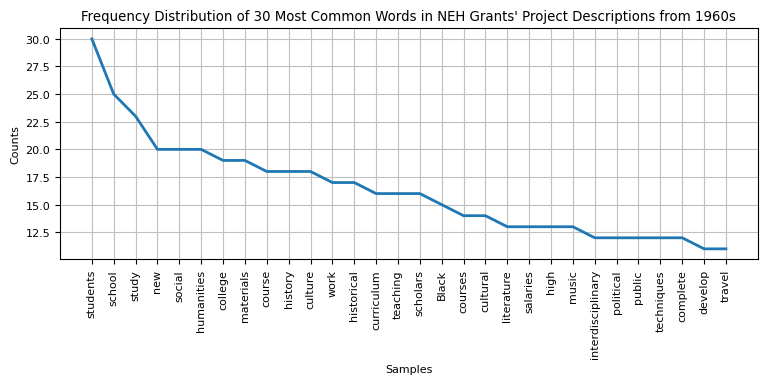

In [23]:
fdist_no_stopwords = FreqDist(no_stopwords)
# Customise the width and height of the plot
plt.figure(figsize = (9, 3))                
# Customise the font size of the title, axes names, and axes labels
plt.rc('font', size=8)
n_words = 30
plot_title = "Frequency Distribution of {n} Most Common Words in NEH Grants' Project Descriptions from {year}s".format(n=n_words, year=y)
fdist_no_stopwords.plot(n_words, title=plot_title)
plt.show()

Visualize the most common stems (words' roots) in the descriptions:

In [25]:
stemmer = nltk.PorterStemmer()
stems = [stemmer.stem(w) for w in no_stopwords]
print(stems[:10])

['studi', 'reform', 'activ', 'consum', 'leagu', 'compar', 'european', 'leagu', 'develop', 'new']


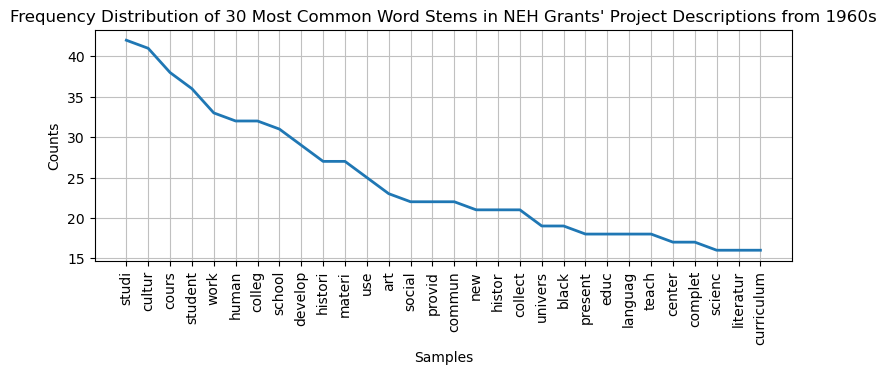

In [26]:
fdist_stems = FreqDist(stems)
# Customise the width and height of the plot
plt.figure(figsize = (9, 3))                
# Customise the font size of the title, axes names, and axes labels
plt.rc('font', size=10)
n_words = 30
plot_title = "Frequency Distribution of {n} Most Common Word Stems in NEH Grants' Project Descriptions from {year}s".format(n=n_words, year=y)
fdist_stems.plot(n_words, title=plot_title)
plt.show()